In [ ]:
from cloudvolume import CloudVolume
from skimage.transform import downscale_local_mean
import napari
from skimage import io
import random
import h5py
from skimage import measure
from brainlit.preprocessing import removeSmallCCs
import numpy as np 
import matplotlib.pyplot as plt 
import subprocess
import tables
from napari_animation import AnimationWidget
from tqdm import tqdm
import pickle
from parse_ara import *
import networkx as nx
import seaborn as sns
import pandas as pd
import brainrender
import scipy.ndimage as ndi
from skimage.morphology import skeletonize
from os import listdir
from os.path import isfile, join
from rabies_somadetector_data import brain2paths, brain2centers
%gui qt5

In [17]:
brain = "r2"
channel = "3channel"
dir = brain2paths[brain][0]
vol_fg = CloudVolume(dir, parallel=1, mip=0, fill_missing=False)
dir = brain2paths[brain][1]
vol_bg = CloudVolume(dir, parallel=1, mip=0, fill_missing=False)
dir = brain2paths[brain][2]
vol_endo = CloudVolume(dir, parallel=1, mip=0, fill_missing=False)
print(vol_fg.shape)

soma_centers = brain2centers[brain][0][0]
nonsoma_centers = brain2centers[brain][1][2]

print(f"{len(soma_centers)} soma centers")
print(f"{len(nonsoma_centers)} nonsoma centers")


(5668, 8790, 3300, 1)


IndexError: list index out of range

## Save images

In [ ]:
dset_name = "test"

# type = "pos"
# for i, center in enumerate(soma_centers):
#     if i >= 30 and i < 40:
#         pass
#     else:
#         continue
#     image_fg = vol_fg[center[0]-24:center[0]+25,center[1]-24:center[1]+25, center[2]-24:center[2]+25]
#     image_fg = image_fg[:,:,:,0]
#     image_bg = vol_bg[center[0]-24:center[0]+25,center[1]-24:center[1]+25, center[2]-24:center[2]+25]
#     image_bg = image_bg[:,:,:,0]
#     image_endo = vol_endo[center[0]-24:center[0]+25,center[1]-24:center[1]+25, center[2]-24:center[2]+25]
#     image_endo = image_endo[:,:,:,0]

#     image = np.squeeze(np.stack([image_fg, image_bg, image_endo], axis=0))
        
#     fname = f"/Users/thomasathey/Documents/mimlab/mouselight/ailey/soma_detection/brain{brain}/{channel}/{dset_name}/{int(center[0])}_{int(center[1])}_{int(center[2])}_{type}.h5"
#     with h5py.File(fname, "w") as f:
#         dset = f.create_dataset("image_3channel", data=image)

type = "neg"
for i, center in enumerate(nonsoma_centers):
    if i == 9:
        pass
    else:
        continue
    image_fg = vol_fg[center[0]-24:center[0]+25,center[1]-24:center[1]+25, center[2]-24:center[2]+25]
    image_fg = image_fg[:,:,:,0]
    image_bg = vol_bg[center[0]-24:center[0]+25,center[1]-24:center[1]+25, center[2]-24:center[2]+25]
    image_bg = image_bg[:,:,:,0]
    image_endo = vol_endo[center[0]-24:center[0]+25,center[1]-24:center[1]+25, center[2]-24:center[2]+25]
    image_endo = image_endo[:,:,:,0]


    image = np.squeeze(np.stack([image_fg, image_bg, image_endo], axis=0))
        
    fname = f"/Users/thomasathey/Documents/mimlab/mouselight/ailey/soma_detection/brain{brain}/{channel}/{dset_name}/{int(center[0])}_{int(center[1])}_{int(center[2])}_{type}.h5"
    with h5py.File(fname, "w") as f:
        dset = f.create_dataset("image_3channel", data=image)
        

## Evaluate performance

['3237_5790_1859_pos_Probabilities.h5', '4116_4527_1725_neg_Probabilities.h5', '1991_2464_2106_pos_Probabilities.h5', '4277_5606_1757_neg_Probabilities.h5', '891_4202_1717_pos_Probabilities.h5', '3190_2247_2101_pos_Probabilities.h5', '2408_703_1708_neg_Probabilities.h5', '5517_3281_1731_neg_Probabilities.h5', '2956_1910_1891_pos_Probabilities.h5', '3208_6492_1802_neg_Probabilities.h5', '4256_5383_1950_pos_Probabilities.h5', '1791_4388_1717_neg_Probabilities.h5', '3121_6361_1692_pos_Probabilities.h5', '5121_3508_1731_neg_Probabilities.h5', '974_3781_1719_neg_Probabilities.h5', '2297_4473_1717_neg_Probabilities.h5', '2692_2204_1892_pos_Probabilities.h5', '2674_877_1708_neg_Probabilities.h5', '3252_2362_2100_pos_Probabilities.h5', '2142_2135_1907_pos_Probabilities.h5']
threshold: 0.05: precision: 0.6363636363636364, recall: 0.7, f-score: 0.6666666666666666 for 10 positive samples in 20 images
threshold: 0.1: precision: 0.7, recall: 0.7, f-score: 0.7 for 10 positive samples in 20 images
th

<matplotlib.legend.Legend object at 0x17ad78100>

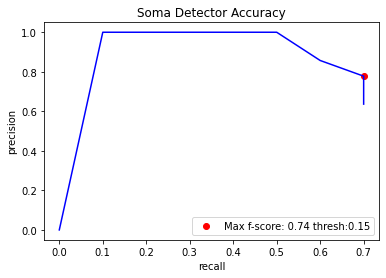

In [18]:
recalls = []
precisions = []

files_dir = f"/Users/thomasathey/Documents/mimlab/mouselight/ailey/soma_detection/brain{brain}/{channel}/test/"
onlyfiles = [f for f in listdir(files_dir) if isfile(join(files_dir, f))]
#test_files = [f for f in onlyfiles if f[:4] == "test"]
test_files = [f for f in onlyfiles if "Probabilities" in f] #"probabilities"
print(test_files)

size_thresh = 500

for threshold in np.arange(0.05,1.0,0.05):
    tot_pos = 0
    true_pos = 0
    false_pos = 0
    for filename in tqdm(test_files, disable=True):
        fname = files_dir + filename
        f = h5py.File(fname, "r")
        pred = f.get("exported_data")
        pred = pred[0,:,:,:]
        mask = pred>threshold
        labels = measure.label(mask)
        props = measure.regionprops(labels)

        if "pos" in filename: 
            first = True
            tot_pos += 1
            for prop in props:
                if prop["area"] > size_thresh:
                    if first:
                        true_pos += 1
                        first = False
                    else:
                        false_pos += 1
        elif "neg" in filename:
            for prop in props:
                if prop["area"] > size_thresh:
                    false_pos += 1

    recall = true_pos/tot_pos
    recalls.append(recall)
    if true_pos + false_pos == 0:
        precision = 0
    else:
        precision = true_pos/(true_pos + false_pos)
    precisions.append(precision)
    if precision == 0 and recall == 0:
        fscore = 0
    else:
        fscore = 2*precision*recall/(precision+recall)
    print(f"threshold: {threshold}: precision: {precision}, recall: {recall}, f-score: {fscore} for {tot_pos} positive samples in {len(test_files)} images")

fscores = [2*precision*recall/(precision+recall) if (precision != 0 and recall != 0) else 0 for precision,recall in zip(precisions, recalls) ]
idx = np.argmax(fscores)
best_threshold = np.arange(0.05,1.0,0.05)[idx]
plt.plot(recalls, precisions, c='b')
plt.scatter(recalls[idx], precisions[idx], c='r', label=f"Max f-score: {fscores[idx]:.2f} thresh:{best_threshold:.2f}")
plt.xlabel("recall")
plt.ylabel("precision")
plt.title("Soma Detector Accuracy")
plt.legend()


In [13]:
size_thresh = 500

for filename in tqdm(test_files, disable=True):
    print(f"*************File: {filename}*********")
    im_fname = files_dir + filename[:-17] + ".h5"
    fname = files_dir + filename
    f = h5py.File(fname, "r")
    pred = f.get("exported_data")
    pred = pred[0,:,:,:]
    mask = pred>best_threshold
    labels = measure.label(mask)
    props = measure.regionprops(labels)

    if "pos" in filename: 
        first = True
        tot_pos += 1
        for prop in props:
            area = prop["area"]
            if area > size_thresh:
                print(f"area of detected object: {area}")
                if first:
                    true_pos += 1
                    first = False
                else:
                    print(f"Soma false positive Area: {area}")
                    f = h5py.File(im_fname, "r")
                    im = f.get("image_3channel")
                    viewer = napari.Viewer(ndisplay=3)
                    viewer.add_image(im[0,:,:,:])
                    viewer.add_image(im[1,:,:,:])
                    viewer.add_image(im[2,:,:,:])
                    viewer.add_labels(mask)
                    viewer.add_labels(labels == prop["label"], name=f"soma false positive area: {area}")
                    false_pos += 1
        if first == True:
            print(f"Soma false negative")
            f = h5py.File(im_fname, "r")
            im = f.get("image_3channel")
            viewer = napari.Viewer(ndisplay=3)
            viewer.add_image(im[0,:,:,:])
            viewer.add_image(im[1,:,:,:])
            viewer.add_image(im[2,:,:,:])
            viewer.add_labels(mask, name="Soma false negative")
    elif "neg" in filename:
        for prop in props:
            area = prop["area"]
            if area > size_thresh:
                print(f"file {filename} Nonsoma false positive Area: {area}")
                f = h5py.File(im_fname, "r")
                im = f.get("image_3channel")
                viewer = napari.Viewer(ndisplay=3)
                viewer.add_image(im[0,:,:,:])
                viewer.add_image(im[1,:,:,:])
                viewer.add_image(im[2,:,:,:])
                viewer.add_labels(mask)
                viewer.add_labels(labels == prop["label"], name=f"nonsoma false positive area: {area}")
                false_pos += 1

*************File: 3237_5790_1859_pos_Probabilities.h5*********
area of detected object: 2369
*************File: 4116_4527_1725_neg_Probabilities.h5*********
*************File: 1991_2464_2106_pos_Probabilities.h5*********
Soma false negative
*************File: 4277_5606_1757_neg_Probabilities.h5*********
file 4277_5606_1757_neg_Probabilities.h5 Nonsoma false positive Area: 2958
*************File: 891_4202_1717_pos_Probabilities.h5*********
area of detected object: 2614
*************File: 3190_2247_2101_pos_Probabilities.h5*********
Soma false negative
*************File: 2408_703_1708_neg_Probabilities.h5*********
*************File: 5517_3281_1731_neg_Probabilities.h5*********
file 5517_3281_1731_neg_Probabilities.h5 Nonsoma false positive Area: 2230
*************File: 2956_1910_1891_pos_Probabilities.h5*********
area of detected object: 824
*************File: 3208_6492_1802_neg_Probabilities.h5*********
*************File: 4256_5383_1950_pos_Probabilities.h5*********
area of detected ob

In [14]:
best_threshold

0.15000000000000002

## make point layer - ?????

In [ ]:

point_path = "precomputed://https://dlab-colm.neurodata.io/2021_10_06/8557/point_preds"
info = CloudVolume.create_new_info(
    num_channels    = 1,
    layer_type      = 'segmentation',
    data_type       = 'uint64', # Channel images might be 'uint8'
    # raw, jpeg, compressed_segmentation, fpzip, kempressed, compresso
    encoding        = 'raw', 
    resolution      = [4, 4, 40], # Voxel scaling, units are in nanometers
    voxel_offset    = [0, 0, 0], # x,y,z offset in voxels from the origin
    mesh            = 'mesh',
    # Pick a convenient size for your underlying chunk representation
    # Powers of two are recommended, doesn't need to cover image exactly
    chunk_size      = [ 512, 512, 16 ], # units are voxels
    volume_size     = [ 250000, 250000, 25000 ], # e.g. a cubic millimeter dataset
)
vol = CloudVolume(point_path, info=info)
vol.commit_info()

In [ ]:
new_somas = []
for soma in somas:
    if soma[2] <= 3000:
        new_somas.append(soma)
len(new_somas)

In [ ]:
soma_ra = np.array(new_somas)
plt.hist(soma_ra[:,2])

In [ ]:
import napari
viewer = napari.Viewer(ndisplay=3)

# Download slices

In [ ]:
im_fg = vol_fg[3100:3500,4500:4900,1400:1800, 0]
im_bg = vol_bg[3100:3500,4500:4900,1400:1800, 0]
im_endo = vol_endo[3100:3500,4500:4900,1400:1800, 0]

viewer = napari.Viewer(ndisplay=3)
viewer.add_image(np.squeeze(im_fg))
viewer.add_image(np.squeeze(im_bg))
viewer.add_image(np.squeeze(im_endo))

## Check ilastik

In [ ]:
im_fg = vol_fg[3100:3500,4500:4900,1400:1800, 0]
im_bg = vol_bg[3100:3500,4500:4900,1400:1800, 0]
im_endo = vol_endo[3100:3500,4500:4900,1400:1800, 0]

image = np.squeeze(np.stack([im_fg, im_bg, im_endo], axis=0))
fname = "/Users/thomasathey/Desktop/im.h5"

with h5py.File(fname, "w") as f:
    dset = f.create_dataset("image_3channel", data=image)

subprocess.run(["/Applications/ilastik-1.3.3post3-OSX.app/Contents/ilastik-release/run_ilastik.sh", "--headless", "--project=/Users/thomasathey/Documents/mimlab/mouselight/ailey/soma_detection/matt_soma_rabies_pix_3ch.ilp", fname], stdout=subprocess.PIPE, stderr=subprocess.PIPE)



In [ ]:
f = h5py.File("/Users/thomasathey/Desktop/im_Probabilities.h5", "r")
pred = f.get("exported_data")

pred = pred[0,:,:,:]

mask = pred > 0.55
labels = measure.label(mask)
props = measure.regionprops(labels)

results = []
for prop in props:
    if prop["area"] > 500:
        location = list(np.add((0,0,0), prop["centroid"]))
        print(location)

viewer = napari.Viewer(ndisplay=3)
viewer.add_image(np.squeeze(im_fg))
viewer.add_labels(mask)

In [ ]:
import math
import numpy as np
new_pts = []
for point in a:
    first = math.isclose(point[0],int(point[0]))
    second = math.isclose(np.abs(point[1]-int(point[1])), 0.5)
    third = math.isclose(np.abs(point[2]-int(point[2])), 0.5)
    if first and second and third:
        continue
    else:
        new_pts.append(point)